In [102]:
import numpy as np
from utils import read_dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import zscore, pearsonr, spearmanr, ttest_ind, f_oneway
from joblib import Parallel, delayed

from statsmodels.stats.multitest import multipletests
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from plot import adjust_ax, get_ratio, plot_surface
from stats import get_ci, EVR

N_COMP = 10
N_BIN = 32
N_ROI = 200

pattern_names = ['S-A', 'TP-D', 'SM-V']
pattern_colors = ['#F8B77C', '#D54D55', '#381043', 'grey']

plt.rcParams['axes.titlesize'] = 9    # Default font size for titles
plt.rcParams['axes.labelsize'] = 8     # Default font size for x and y labels
plt.rcParams['xtick.labelsize'] = 7    # Default font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 7    # Default font size for y-axis tick labels
plt.rcParams['font.size'] = 6.5

dir_01 = '../results/01-CPCA'
dir_02 = '../results/02-AgeEffect'

correct_p = lambda x: multipletests(x, alpha=0.05, method='fdr_bh')[1]

In [103]:
def state_occurrence_ratio(dataset):
    data = np.load( f'{dir_01}/{dataset}_cpca_ind.npy', allow_pickle=True).item()
    list_U_mag = np.abs(data['U'] * data['S'][:, np.newaxis, :])
    n_sub, n_tps, n_comp = list_U_mag.shape
    list_state = np.argmax(list_U_mag, axis=2)
    list_state[list_state > 3] = 3
    list_sor = np.asarray([np.unique(state, return_counts=True)[1] for state in list_state]) / n_tps  # State Occurrence Ratio
    age = np.asarray(data['demo']['age'])
    return list_sor, age

def get_ratio(x, y):
    return (np.max(x) - np.min(x)) / (np.max(y) - np.min(y))

def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)  # Use ddof=1 for sample std dev
    n1, n2 = len(group1), len(group2)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    # Cohen's d
    d = (mean1 - mean2) / pooled_std
    return d

# Intrinsic State definition

In [104]:
data = np.load(f'{dir_01}/HCP-D_cpca_ind.npy', allow_pickle=True).item()
list_U = data['U']
list_S = data['S']

### Sample BOLD signal snapshots (Figure 2A)

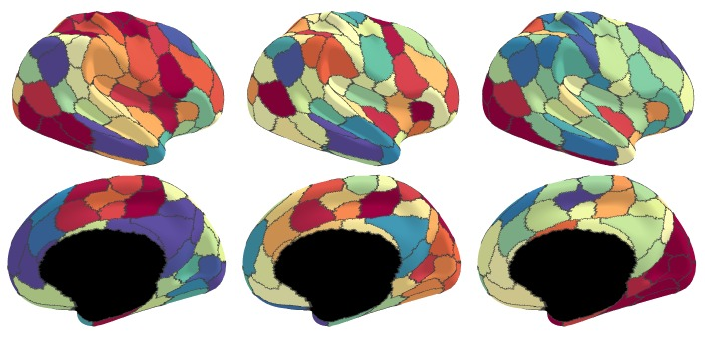

In [105]:
sub = 131
tstart = 750
nt = np.arange(tstart,tstart + 500)
U_mag = np.abs(list_U[sub] * list_S[sub])[nt]

state = np.argmax(U_mag, axis=1)
state[state > 3] = 3

max_t = np.argmax(U_mag, axis=0)
list_pts, demo = read_dataset('HCP-D')
list_pts = list_pts[sub, :, nt][max_t[:3]]

plotter = plot_surface()
plotter.plot_dynamics(list_pts, vmin=-1.64, vmax=1.64, cmap='Spectral_r', hemi='rh')

### State occrrence ratio

In [106]:
list_sor_A, age_A = state_occurrence_ratio('HCP-A')
list_sor_D, age_D = state_occurrence_ratio('HCP-D')

list_sor = np.concatenate((list_sor_A, list_sor_D))
age = np.concatenate((age_A, age_D))

age_dict = {'Children':age < 13, 
            'Adolescent':(age>=13) & (age <18), 
            'EarlyAdulthood':(age>=18) & (age < 23),
            'Adult':age >= 23
}
age_stages = list(age_dict.keys())
n_stages = len(age_stages)

# Print number of individuals for each age stage
_ = [print(key, len(list_sor[age_dict[key], 0])) for key in age_stages]

Children 139
Adolescent 172
EarlyAdulthood 97
Adult 399


### Static functional gradients

In [108]:
gradients = np.load(f'{dir_01}/HCP-D_gradient_ind.npy')
S_fg = np.sqrt(np.sum(np.power(gradients, 2), axis=1))
list_EVR_fg = EVR(S_fg, 200, axis=1)

S = np.load( f'{dir_01}/HCP-D_cpca_ind.npy', allow_pickle=True).item()['S']
list_EVR = EVR(S**2, 200, axis=1)
n_sub = len(list_sor_D)

# Figure 2

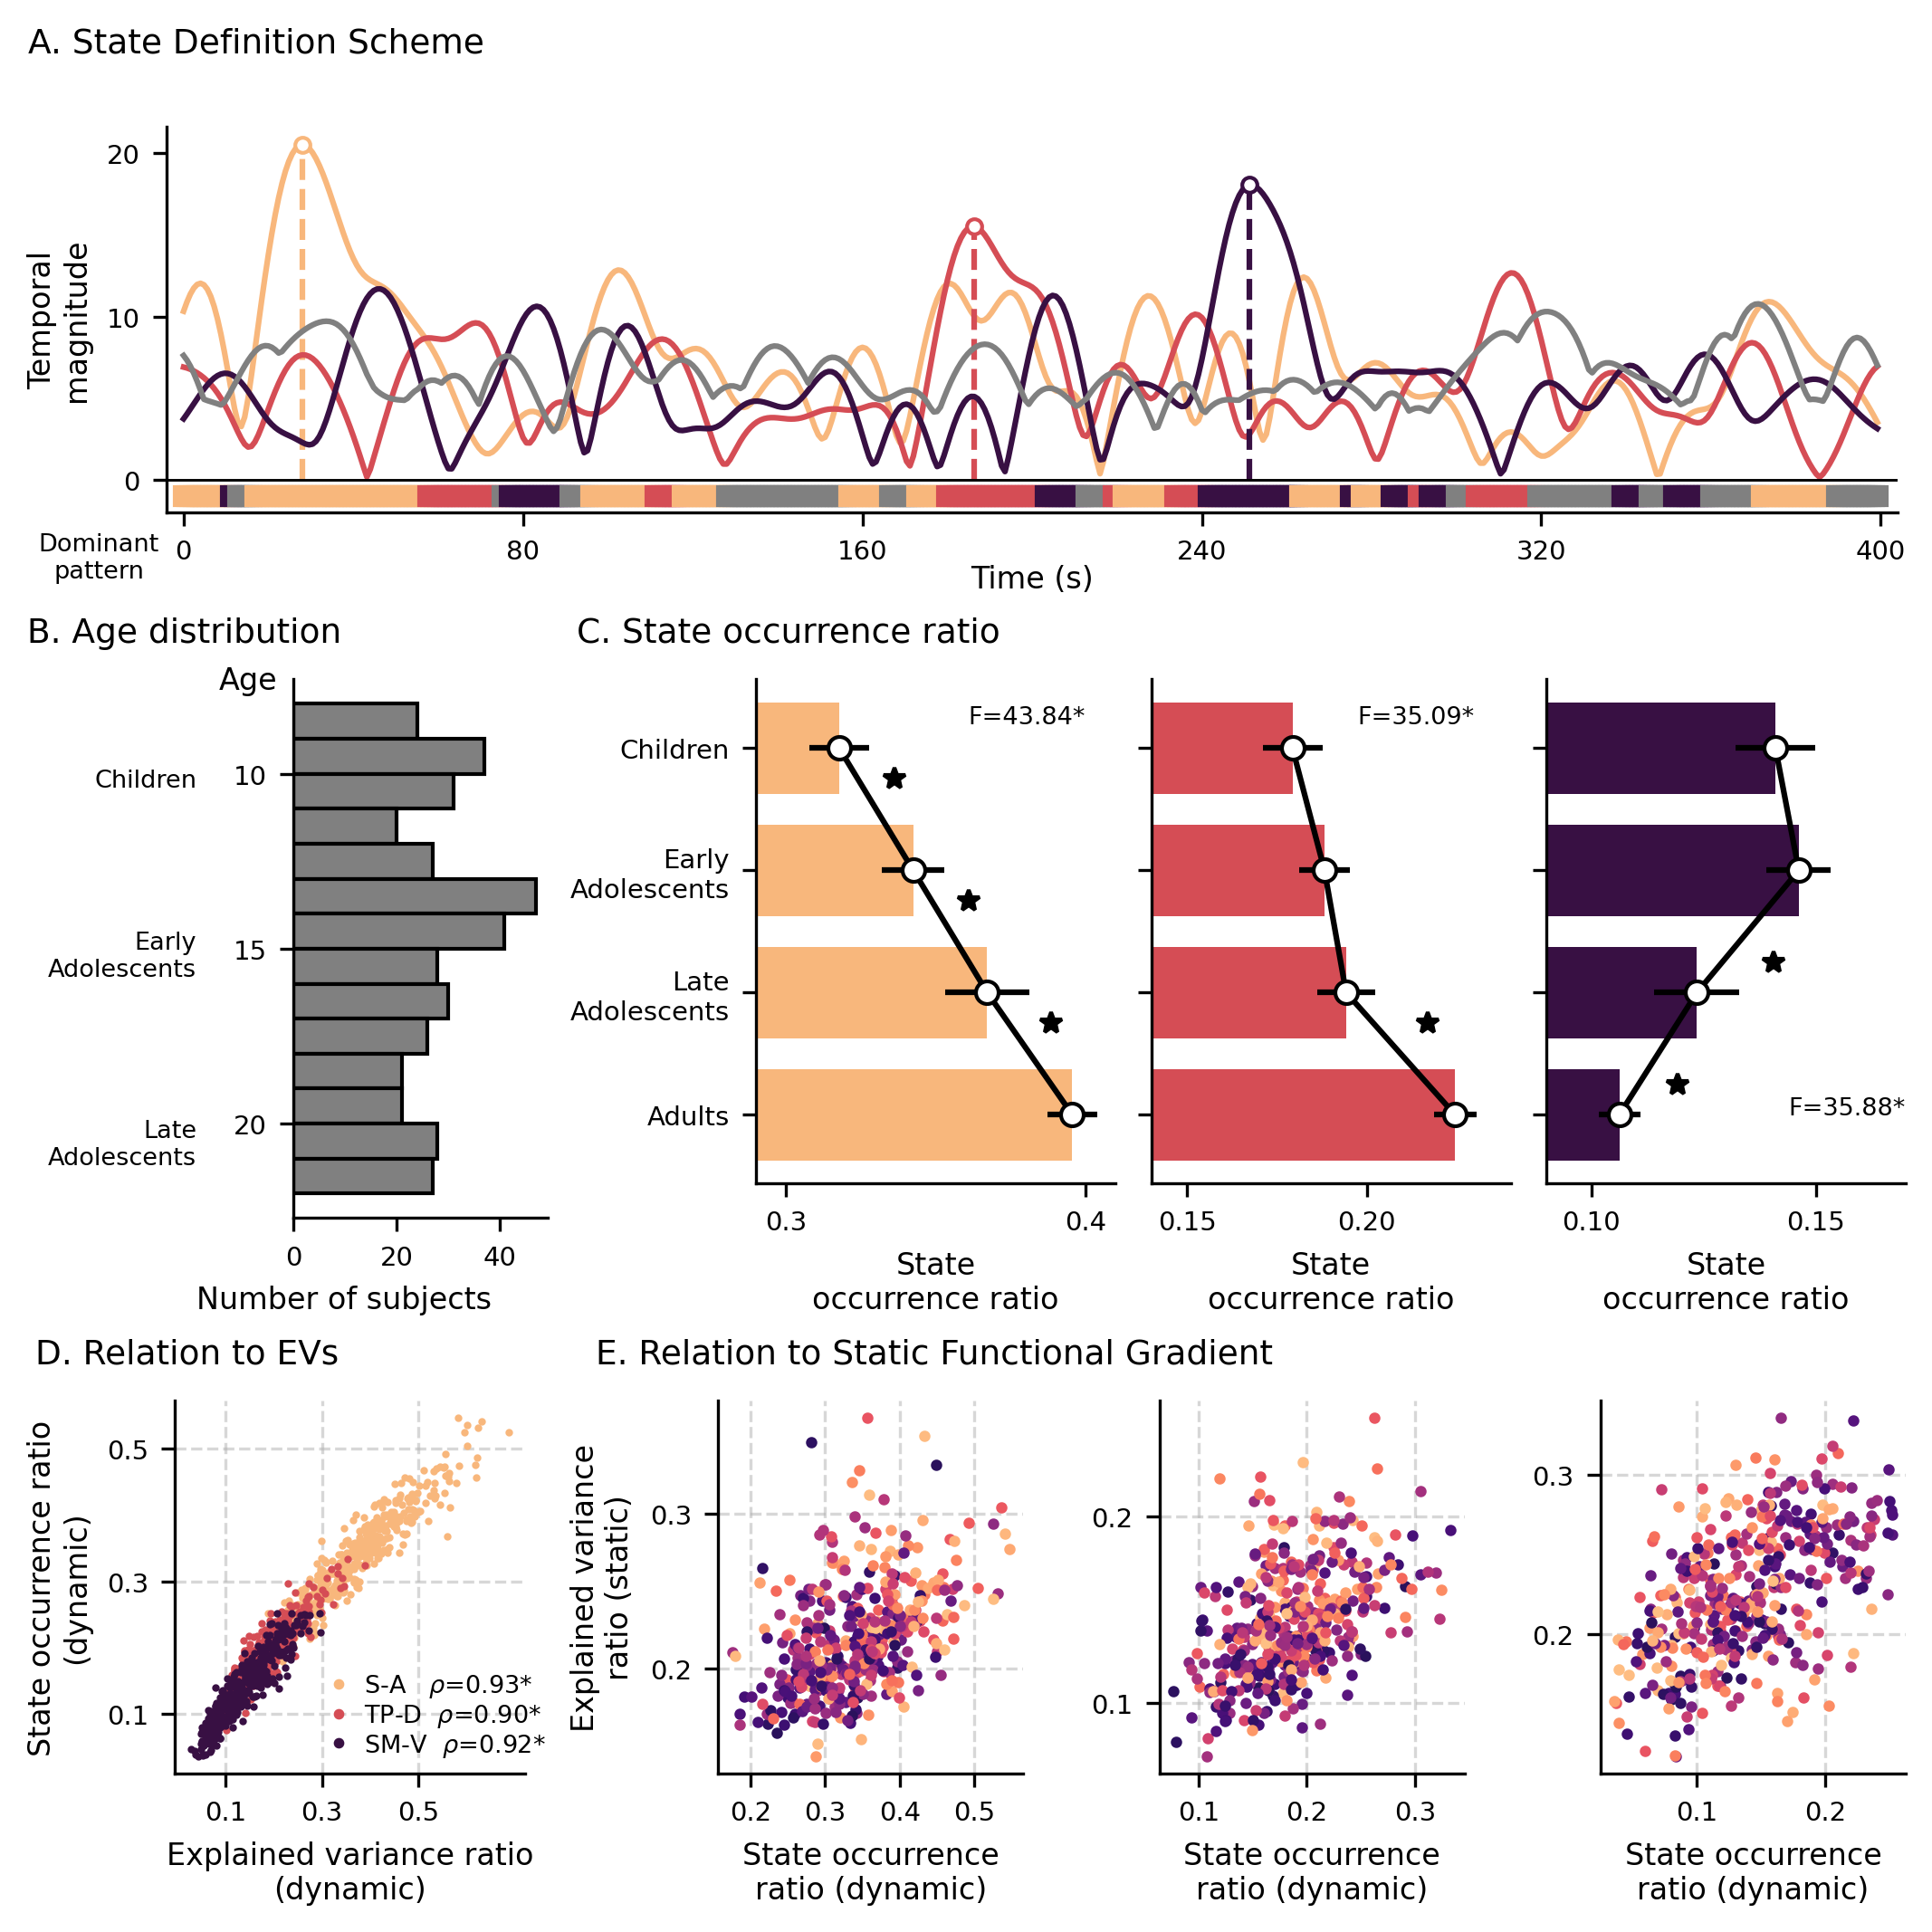

In [109]:
fig = plt.figure(layout='constrained', figsize=(7, 7), dpi=300)
subfigs = fig.subfigures(3, 1, wspace=0, hspace=0, height_ratios=[.9, 1.1, .9])
pad = 10


figA = subfigs[0]
ax = figA.subplots(1)

ax.set_title('A. State Definition Scheme', loc='left', x=-.08, pad=20)

for comp in range(4):
    if comp == 3:
        sig = U_mag[:, 3:].max(axis=1)
    else:
        sig = U_mag[:, comp]
    color = pattern_colors[comp]
    ax.plot(sig, '-', color=color)
    max_t = np.argmax(sig)
    if comp != 3:
        ax.plot([max_t, max_t], [0, sig[max_t]], '--', color=color)
        ax.plot(max_t, sig[max_t], 'o', mfc='white', ms=4, color=color)

for i in range(len(state)):
    color = pattern_colors[state[i]]
    ax.plot(i, -1, 's', color=color, ms=5)

ax.set_xticks(np.arange(0, 501, 100), np.arange(0, 401, 80))
ax.set_yticks([0, 10, 20])
ax.set_xlabel('Time (s)', labelpad=0)
ax.set_ylabel('Temporal\nmagnitude')
ax.spines[['top', 'right']].set_visible(False)
ax.plot([-5, 510], [0, 0], 'k-', lw=.7)
ax.set_ylim(-2)
ax.set_xlim(-5, 505)
ax.text(-25, -6, 'Dominant\npattern', ha='center')

# Figure B, C
figB, figC = subfigs[1].subfigures(1, 2, wspace=0, hspace=0, width_ratios=[1.2, 3])

# Fig.B: Age Distribution
axs = figB.subplots(1, 2, width_ratios=[1, 3])

# Left panner indicating age stage 
ax = axs[0]
ax.set_title('B. Age distribution', loc='left', x=0, pad=pad)
ax.axis('off')

ax.text(2, .8, 'Children', ha='right')
ax.text(2, .45, 'Early\nAdolescents', ha='right')
ax.text(2, .1, 'Late\nAdolescents', ha='right')

ax = axs[1]
ax.hist(age, color='gray', edgecolor='black', bins=np.arange(8, 23), orientation='horizontal')
ax.set_yticks([10, 15, 20])
ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Number of subjects', x=.2)
ax.set_ylabel('Age', rotation='horizontal', y=.97, labelpad=-4)


# Fig.C: State Occurrence Ratio

x = np.arange(n_stages)

axs = figC.subplots(1, 3, width_ratios=[1, 1, 1])

ax = axs[0]
ax.set_title('C. State occurrence ratio', loc='left', x=-.5, pad=pad)


for comp in range(3):
    ax = axs[comp]
    dtr = [list_sor[age_dict[stage], comp].mean() for stage in age_stages]
    ci = [get_ci(list_sor[age_dict[stage], comp]) for stage in age_stages]
    ax.barh(x, height=.75, width=dtr, color=pattern_colors[comp], xerr=ci)
    
    ax.plot(dtr, x, 'ko-', markerfacecolor='w')
    ax.set_yticks(x)
    ax.set_xticks(np.arange(0, 0.5, 0.05))
    ax.spines[['top', 'right']].set_visible(False)
    ax.invert_yaxis()
    ax.set_xlabel('State\noccurrence ratio')
    
    # Difference between Consecutive stages
    list_tp = np.zeros((n_stages-1, 2))
    list_d = np.zeros((n_stages-1, 2))
    for idx in range(n_stages-1):
        stage_prev = list_sor[age_dict[age_stages[idx]], comp]
        stage_next = list_sor[age_dict[age_stages[idx+1]], comp]
        list_tp[idx] = ttest_ind(stage_prev, stage_next)
        list_d[idx] = cohens_d(stage_prev, stage_next)
    # print(comp)
    # print('t', list_tp.round(4))
    # print('d', list_d.round(4))

    valid_change = np.where(list_tp[:, 1] < 0.05)[0]
    corp = correct_p(list_tp[:, 1])
    if len(valid_change) > 0:
        for point in valid_change:
            pt_x = (dtr[point] + dtr[point + 1]) / 2 + np.abs(dtr[point] - dtr[point+1]) / 4
            if dtr[point] > dtr[point+1]:
                pt_y = point + .75
            else:
                pt_y = point + 0.25
            if corp[point] < 0.05:
                marker = 'k*'
            else:
                marker = 'k.'
            ax.plot(pt_x, pt_y, marker)
            
    f, p = f_oneway(*[list_sor[age_dict[key], comp] for key in age_stages])

    px = [.40, .23, .17][comp]
    py = [-.2, -.2, n_stages - 1][comp]
    text = f'F={f.round(2)}'
    if p < 0.05:
        text += '*'
    ax.text(px, py, text, ha='right')        

axs[0].set_xticks(np.arange(0, 0.5, 0.1))
axs[0].set_xlim(.29, .41)
axs[1].set_xlim(.14, .24)
axs[2].set_xlim(.09, .17)
axs[0].set_yticks([0, 1, 2, 3], ['Children', 'Early\nAdolescents', 'Late\nAdolescents', 'Adults'])
axs[1].set_yticks([0, 1, 2, 3], ['']*4)
axs[2].set_yticks([0, 1, 2, 3], ['']*4)


# Fig. D E
figD, figE = subfigs[2].subfigures(1, 2, wspace=0, hspace=0, width_ratios=[1.2, 3])



# Fig.D: Relation to EVs
ax = figD.subplots()
ax.set_title('D. Relation to EVs', loc='left', x=-.4, pad=pad)

ratio = get_ratio(list_EVR[:, :3], list_sor_D[:, :3])
# ax.set_aspect(ratio, adjustable='box') 

for comp in range(3):
    x = list_EVR[:, comp]
    y = list_sor_D[:, comp]
    r = pearsonr(x, y)[0].round(2)
    ax.plot(x, y, 'o', color=pattern_colors[comp], ms=1, label=rf'{pattern_names[comp]:<5s} $\rho$={r:.2f}*')


ax.legend(bbox_to_anchor=(1.1, 0), loc='lower right', frameon=True, facecolor='none', edgecolor='none', 
          markerscale=1.8, handletextpad=0, labelspacing=0.1, borderpad=0.1)

ax.spines[['top', 'right']].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Explained variance ratio\n(dynamic)')
ax.set_ylabel('State occurrence ratio\n(dynamic)')
ax.set_xticks([.1, .3, .5])
ax.set_yticks([.1, .3, .5])


axs = figE.subplots(1, 3, width_ratios=[1, 1, 1])
ax = axs[0]
ax.set_title('E. Relation to Static Functional Gradient', loc='left', x=-.4, pad=pad)


cmap = plt.get_cmap('magma')


for comp in range(3):
    ax = axs[comp]

    mm_age = 1 / (1 + np.exp(-zscore(age_D)))

    ax.set_xticks(np.arange(.1, .71, .1))

    if comp == 0:
        ax.set_ylabel('Explained variance\nratio (static)')
        
    else:
        ax.set_ylabel(' ')

    ax.set_xlabel('State occurrence\nratio (dynamic)')

    ax.set_yticks(np.arange(.1, .71, .1))
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.5)

    for sub in range(n_sub):
        # ax.plot(list_EVR_fg[sub, comp], list_sor_D[sub, comp], 'o', ms=2, color=cmap(mm_age[sub]))
        ax.plot(list_sor_D[sub, comp], list_EVR_fg[sub, comp], 'o', ms=2, color=cmap(mm_age[sub]))

    r = pearsonr(list_EVR_fg[:, comp], list_sor_D[:, comp])[0].round(2)
    ratio = get_ratio(list_sor_D[:, comp], list_EVR_fg[:, comp])
    # ax.set_aspect(ratio, adjustable='box')
    # ax.text(list_EVR_fg[:, comp].max(), list_sor_D[:, comp].min(), rf'$\rho$={r:.2f}*', ha='right')

# Directionality

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

def get_scores(seed=0):
    # Set up stratified k-fold cross-validation based on binned ages
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Initialize a list to hold the R² score for each fold
    list_mse = []
    list_pr = []

    # Cross-validation loop
    for train_index, test_index in kf.split(X, Y_binned):
        # Split the data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Train the model
        pipeline.fit(X_train, Y_train)

        # Make predictions on the test set
        Y_pred = pipeline.predict(X_test)
        list_pr.append(pearsonr(Y_test.ravel(), Y_pred.ravel())[0])
        # list_mse.append(mean_absolute_error(Y_test, Y_pred))


def get_rpmap(seed=0, X=X, Y_binned=Y_binned):
    # Set up stratified k-fold cross-validation based on binned ages
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Initialize a list to hold the R² score for each fold
    list_pr = []

    list_Y_test = []
    list_Y_pred = []
    # Cross-validation loop
    for train_index, test_index in kf.split(X, Y_binned):
        # Split the data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Train the model
        pipeline.fit(X_train, Y_train)

        # Make predictions on the test set
        Y_pred = pipeline.predict(X_test)
        list_Y_pred.append(Y_pred)
        list_Y_test.append(Y_test)
    rp = pearsonr(np.ravel(list_Y_test), np.ravel(list_Y_pred))

    return rp


def ting_method(seed=0):
    # Set up stratified k-fold cross-validation based on binned ages
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Initialize a list to hold the R² score for each fold
    list_pr = []

    list_Y_test = []
    list_Y_pred = []
    # Cross-validation loop
    for train_index, test_index in kf.split(X, Y_binned):
        # Split the data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Train the model
        pipeline.fit(X_train, Y_train)

        # Make predictions on the test set
        Y_pred = pipeline.predict(X_test)
        list_Y_pred.append(Y_pred)
        list_Y_test.append(Y_test)
    rp = pearsonr(np.ravel(list_Y_test), np.ravel(list_Y_pred))

    return list_Y_test, list_Y_pred



def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [17]:
dir_file = '/ocean/projects/bio220042p/shared/data/fmriprep_xcp_RBC'
cog_file = f'{dir_file}/demographics/HCP_Development/cogcomp01.txt'
sub_cog = pd.read_table(cog_file)

score_name = 'nih_totalcogcomp_ageadjusted' # Valid scores : ['nih_totalcogcomp_ageadjusted', 'nih_crycogcomp_ageadjusted', 'nih_fluidcogcomp_ageadjusted']
sub_cog = sub_cog.sort_values('src_subject_id').reset_index(drop=True)
sub_cog = sub_cog[~sub_cog[score_name].isna()]

In [18]:
n_bin = 32
data = np.load(f'{dir_01}/HCP-D_cpca_ind.npy', allow_pickle=True).item()
list_U = np.asarray(data['U'])
demo = data['demo']
age = demo['age'].values.astype(float)

pd_fd = np.load('../data/fd_HCP_development.npy', allow_pickle=True)
pd_fd = pd.DataFrame(pd_fd, columns=['sub', 'REST1_AP', 'REST1_PA', 'REST2_AP', 'REST2_PA', 'mean_fd'])
pd_fd['sub'] = pd_fd['sub'].str.replace('_V1_MR', '')
pd_fd.sort_values('sub')
pd_fd = pd_fd[np.isin(pd_fd['sub'], demo['src_subject_id'])].reset_index(drop=True)
demo['MeanFD'] = pd_fd['mean_fd']

mfd = np.nan_to_num(demo['MeanFD'].values.astype(float))


valid_sub = np.intersect1d(sub_cog.src_subject_id, demo.src_subject_id)
sub_cog = sub_cog[np.isin(sub_cog.src_subject_id, valid_sub)]
patterns = data['patterns'].real[np.isin(demo.src_subject_id, valid_sub)]

In [19]:
# Bin the ages into categories
Y = np.array(sub_cog[score_name]).astype(float)
Y_binned = pd.qcut(Y, q=5, duplicates='drop', labels=False)

# 10-Fold Cross-validation

# Stratified K-Fold Cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
list_segment = np.split(np.arange(n_bin), 4)

In [20]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', PLSRegression(n_components=3)),

])

prediction_dict = {}

for comp in tqdm(range(3)):
    angle_us = np.mod(np.angle(list_U[:, :,  comp]), 2 * np.pi)
    bins = np.linspace(0, 2 * np.pi, n_bin + 1)
    bin_idx = np.digitize(angle_us, bins) - 1
    bcounts = np.asarray([(bin_idx == i).sum(axis=1) for i in range(n_bin)])
    
    # Dynamic Pattern weighted by State occurrence ratio
    list_X = patterns[:, comp] * bcounts.T[np.isin(demo.src_subject_id, valid_sub), :, np.newaxis]

    list_prediction_score = []
    for segment in list_segment:
        X = list_X[:, segment].reshape(len(list_X), -1)
        prediction_score = np.asarray(Parallel(n_jobs=8)(delayed(get_scores)(seed) for seed in range(1000)))
        list_prediction_score.append(prediction_score)
    prediction_dict[comp] = list_prediction_score
np.save(f'{dir_02}/cogscore.npy', prediction_dict)

100%|██████████| 3/3 [02:02<00:00, 40.70s/it]


In [50]:
rpmap_dict = {}

for comp in tqdm(range(3)):
    angle_us = np.mod(np.angle(list_U[:, :,  comp]), 2 * np.pi)
    bins = np.linspace(0, 2 * np.pi, n_bin + 1)
    bin_idx = np.digitize(angle_us, bins) - 1
    bcounts = np.asarray([(bin_idx == i).sum(axis=1) for i in range(n_bin)])
    
    # Dynamic Pattern weighted by State occurrence ratio
    list_X = patterns[:, comp] * bcounts.T[np.isin(demo.src_subject_id, valid_sub), :, np.newaxis]
    # Dynamic Patterns not weighted by state occurrene ratio
    # list_X = patterns[:, comp]

    list_prediction_score = []
    for segment in list_segment:
        X = list_X[:, segment].reshape(len(list_X), -1)
        prediction_score = np.asarray(Parallel(n_jobs=8)(delayed(get_rpmap)(seed) for seed in range(1000)))
        list_prediction_score.append(prediction_score)
    rpmap_dict[comp] = list_prediction_score

100%|██████████| 3/3 [02:03<00:00, 41.09s/it]


In [64]:
null_dict = {}

for comp in tqdm(range(3)):
    angle_us = np.mod(np.angle(list_U[:, :,  comp]), 2 * np.pi)
    bins = np.linspace(0, 2 * np.pi, n_bin + 1)
    bin_idx = np.digitize(angle_us, bins) - 1
    bcounts = np.asarray([(bin_idx == i).sum(axis=1) for i in range(n_bin)])
    
    # Dynamic Pattern weighted by State occurrence ratio
    list_X = patterns[:, comp] * bcounts.T[np.isin(demo.src_subject_id, valid_sub), :, np.newaxis]
    # Dynamic Patterns not weighted by state occurrene ratio
    # list_X = patterns[:, comp]

    list_prediction_score = []
    for segment in list_segment:
        X = list_X[:, segment].reshape(len(list_X), -1)
        prediction_score = np.asarray(Parallel(n_jobs=8)(delayed(get_rpmap)(seed=seed, Y_binned=Y_binned[np.random.RandomState(seed=seed).permutation(len(Y_binned))]) for seed in range(1000)))
        list_prediction_score.append(prediction_score)
    null_dict[comp] = list_prediction_score

100%|██████████| 3/3 [01:55<00:00, 38.60s/it]


In [88]:
comp = 0
seg = 0
for comp in range(3):
    print(comp)
    for seg in range(4):
        mean_r = np.asarray(rpmap_dict[comp])[seg, :, 0].mean()
        p = np.sum(mean_r < np.asarray(null_dict[comp])[seg, :, 0])  / 1000
        print(mean_r.round(2), p)

0
0.17 0.053
0.19 0.013
0.2 0.004
0.24 0.0
1
0.2 0.003
0.14 0.213
0.17 0.044
0.14 0.184
2
0.15 0.161
0.12 0.508
0.16 0.07
0.12 0.445


In [12]:
import itertools
prediction_dict = np.load(f'{dir_02}/cogscore.npy', allow_pickle=True).item()
comp = 1
list_scores = prediction_dict[comp] 

ttest_dict = dict()
list_direction = []
list_t = []
list_p = []
for i, j in itertools.combinations(np.arange(4), 2):
    t, p = ttest_ind(list_scores[i], list_scores[j])
    list_direction.append((i, j))
    list_t.append(t)
    list_p.append(p)
corp = correct_p(list_p)

In [13]:
print(np.asarray(list_direction)[corp < 0.05])
print(np.asarray(list_t)[corp < 0.05])

[[0 1]
 [0 2]
 [0 3]
 [1 2]
 [1 3]
 [2 3]]
[ 44.82228984  21.6215057   42.33571215 -22.85499157  -2.43374504
  20.41331912]


In [14]:
%%time
plotter = plot_surface()
patterns = np.load(f'{dir_01}/HCP-D_cpca_grp.npy', allow_pickle=True).item()['patterns'].real
list_img = [plotter.plot_dynamics(zscore(patterns[comp, ::5]), cmap='Spectral_r', show=False, vmin=-1.64, vmax=1.64) for comp in range(3)]

CPU times: user 2.12 s, sys: 197 ms, total: 2.31 s
Wall time: 18.3 s


In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [16]:
def spearmanr_with_covariate(x, y, cov):
    cov = sm.add_constant(mfd)
    model_x = sm.OLS(x, cov).fit()
    model_y = sm.OLS(y, cov).fit()

    x_residuals = model_x.resid
    y_residuals = model_y.resid
    return spearmanr(x_residuals, y_residuals)

Seg #3: 0.17 ± 0.04
Seg #3: 0.19 ± 0.03
Seg #3: 0.2 ± 0.03
Seg #3: 0.25 ± 0.03


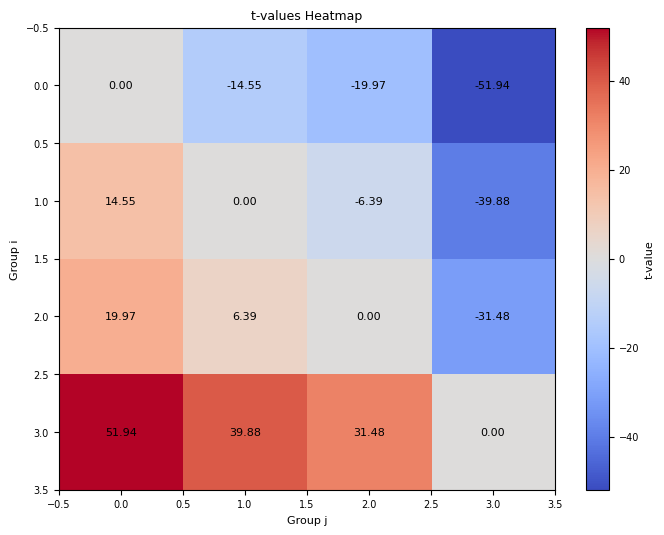

In [17]:
prediction_dict = np.load(f'{dir_02}/cogscore.npy', allow_pickle=True).item()

comp = 0

for seg in range(4):
    score = prediction_dict[comp][seg]
    print(f'Seg #{i+1}: {np.mean(score).round(2)} ± {np.std(score).round(2)}')
    

tp_map = np.zeros((4, 4, 2))
for i in range(4):
    for j in range(4):
        tp_map[i,j] = ttest_ind(prediction_dict[comp][i], prediction_dict[comp][j])

plt.figure(figsize=(8, 6))
t_values = tp_map[:, :, 0]
p_values = tp_map[:, :, 1]
im = plt.imshow(t_values, cmap='coolwarm', aspect='auto')
plt.colorbar(im, label='t-value')

# Add text annotations
for i in range(t_values.shape[0]):
    for j in range(t_values.shape[1]):
        text = f"{t_values[i, j]:.2f}"  # Format t-values to 2 decimal points
        plt.text(j, i, text, ha='center', va='center', color='black', fontsize=8)

plt.title('t-values Heatmap')
plt.xlabel('Group j')
plt.ylabel('Group i')
plt.show()

In [18]:
print(ttest_ind(np.ravel(prediction_dict[0][:2]), np.ravel(prediction_dict[0][2:])))
print(cohens_d(np.ravel(prediction_dict[0][:2]), np.ravel(prediction_dict[0][2:])))

Ttest_indResult(statistic=-36.33599406276823, pvalue=4.63799334326228e-250)
-1.1490450228470286


In [19]:
from scipy.stats import t

# Given values
r = prediction_dict[2][3]  # Pearson correlation coefficient
n = 1000   # Number of samples

# Step 1: Calculate t-statistic
t_stat = r * ((n - 2) ** 0.5) / ((1 - r**2) ** 0.5)

# Step 2: Degrees of Freedom
df = n - 2

# Step 3: Two-tailed p-value
p_value = 2 * t.sf(abs(t_stat), df)

(correct_p(p_value) < 0.05).sum()

959

In [20]:
print(np.mean(prediction_dict[0], axis=1))
print(np.std(prediction_dict[0], axis=1))

[0.17181278 0.1933328  0.2025637  0.24718282]
[0.0351137  0.03084381 0.03371171 0.02950372]


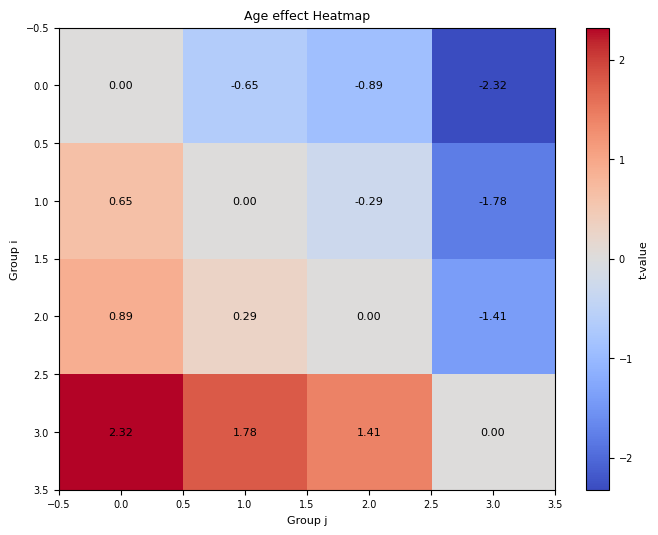

In [21]:
prediction_dict = np.load(f'{dir_02}/cogscore.npy', allow_pickle=True).item()

comp = 0
tp_map = np.zeros((4, 4, 2))
for i in range(4):
    for j in range(4):
        tp_map[i,j] = cohens_d(prediction_dict[comp][i], prediction_dict[comp][j])

plt.figure(figsize=(8, 6))
t_values = tp_map[:, :, 0]
p_values = tp_map[:, :, 1]
im = plt.imshow(t_values, cmap='coolwarm', aspect='auto')
plt.colorbar(im, label='t-value')

# Add text annotations
for i in range(t_values.shape[0]):
    for j in range(t_values.shape[1]):
        text = f"{t_values[i, j]:.2f}"  # Format t-values to 2 decimal points
        plt.text(j, i, text, ha='center', va='center', color='black', fontsize=8)

plt.title('Age effect Heatmap')
plt.xlabel('Group j')
plt.ylabel('Group i')
plt.show()

NameError: name 'list_img' is not defined

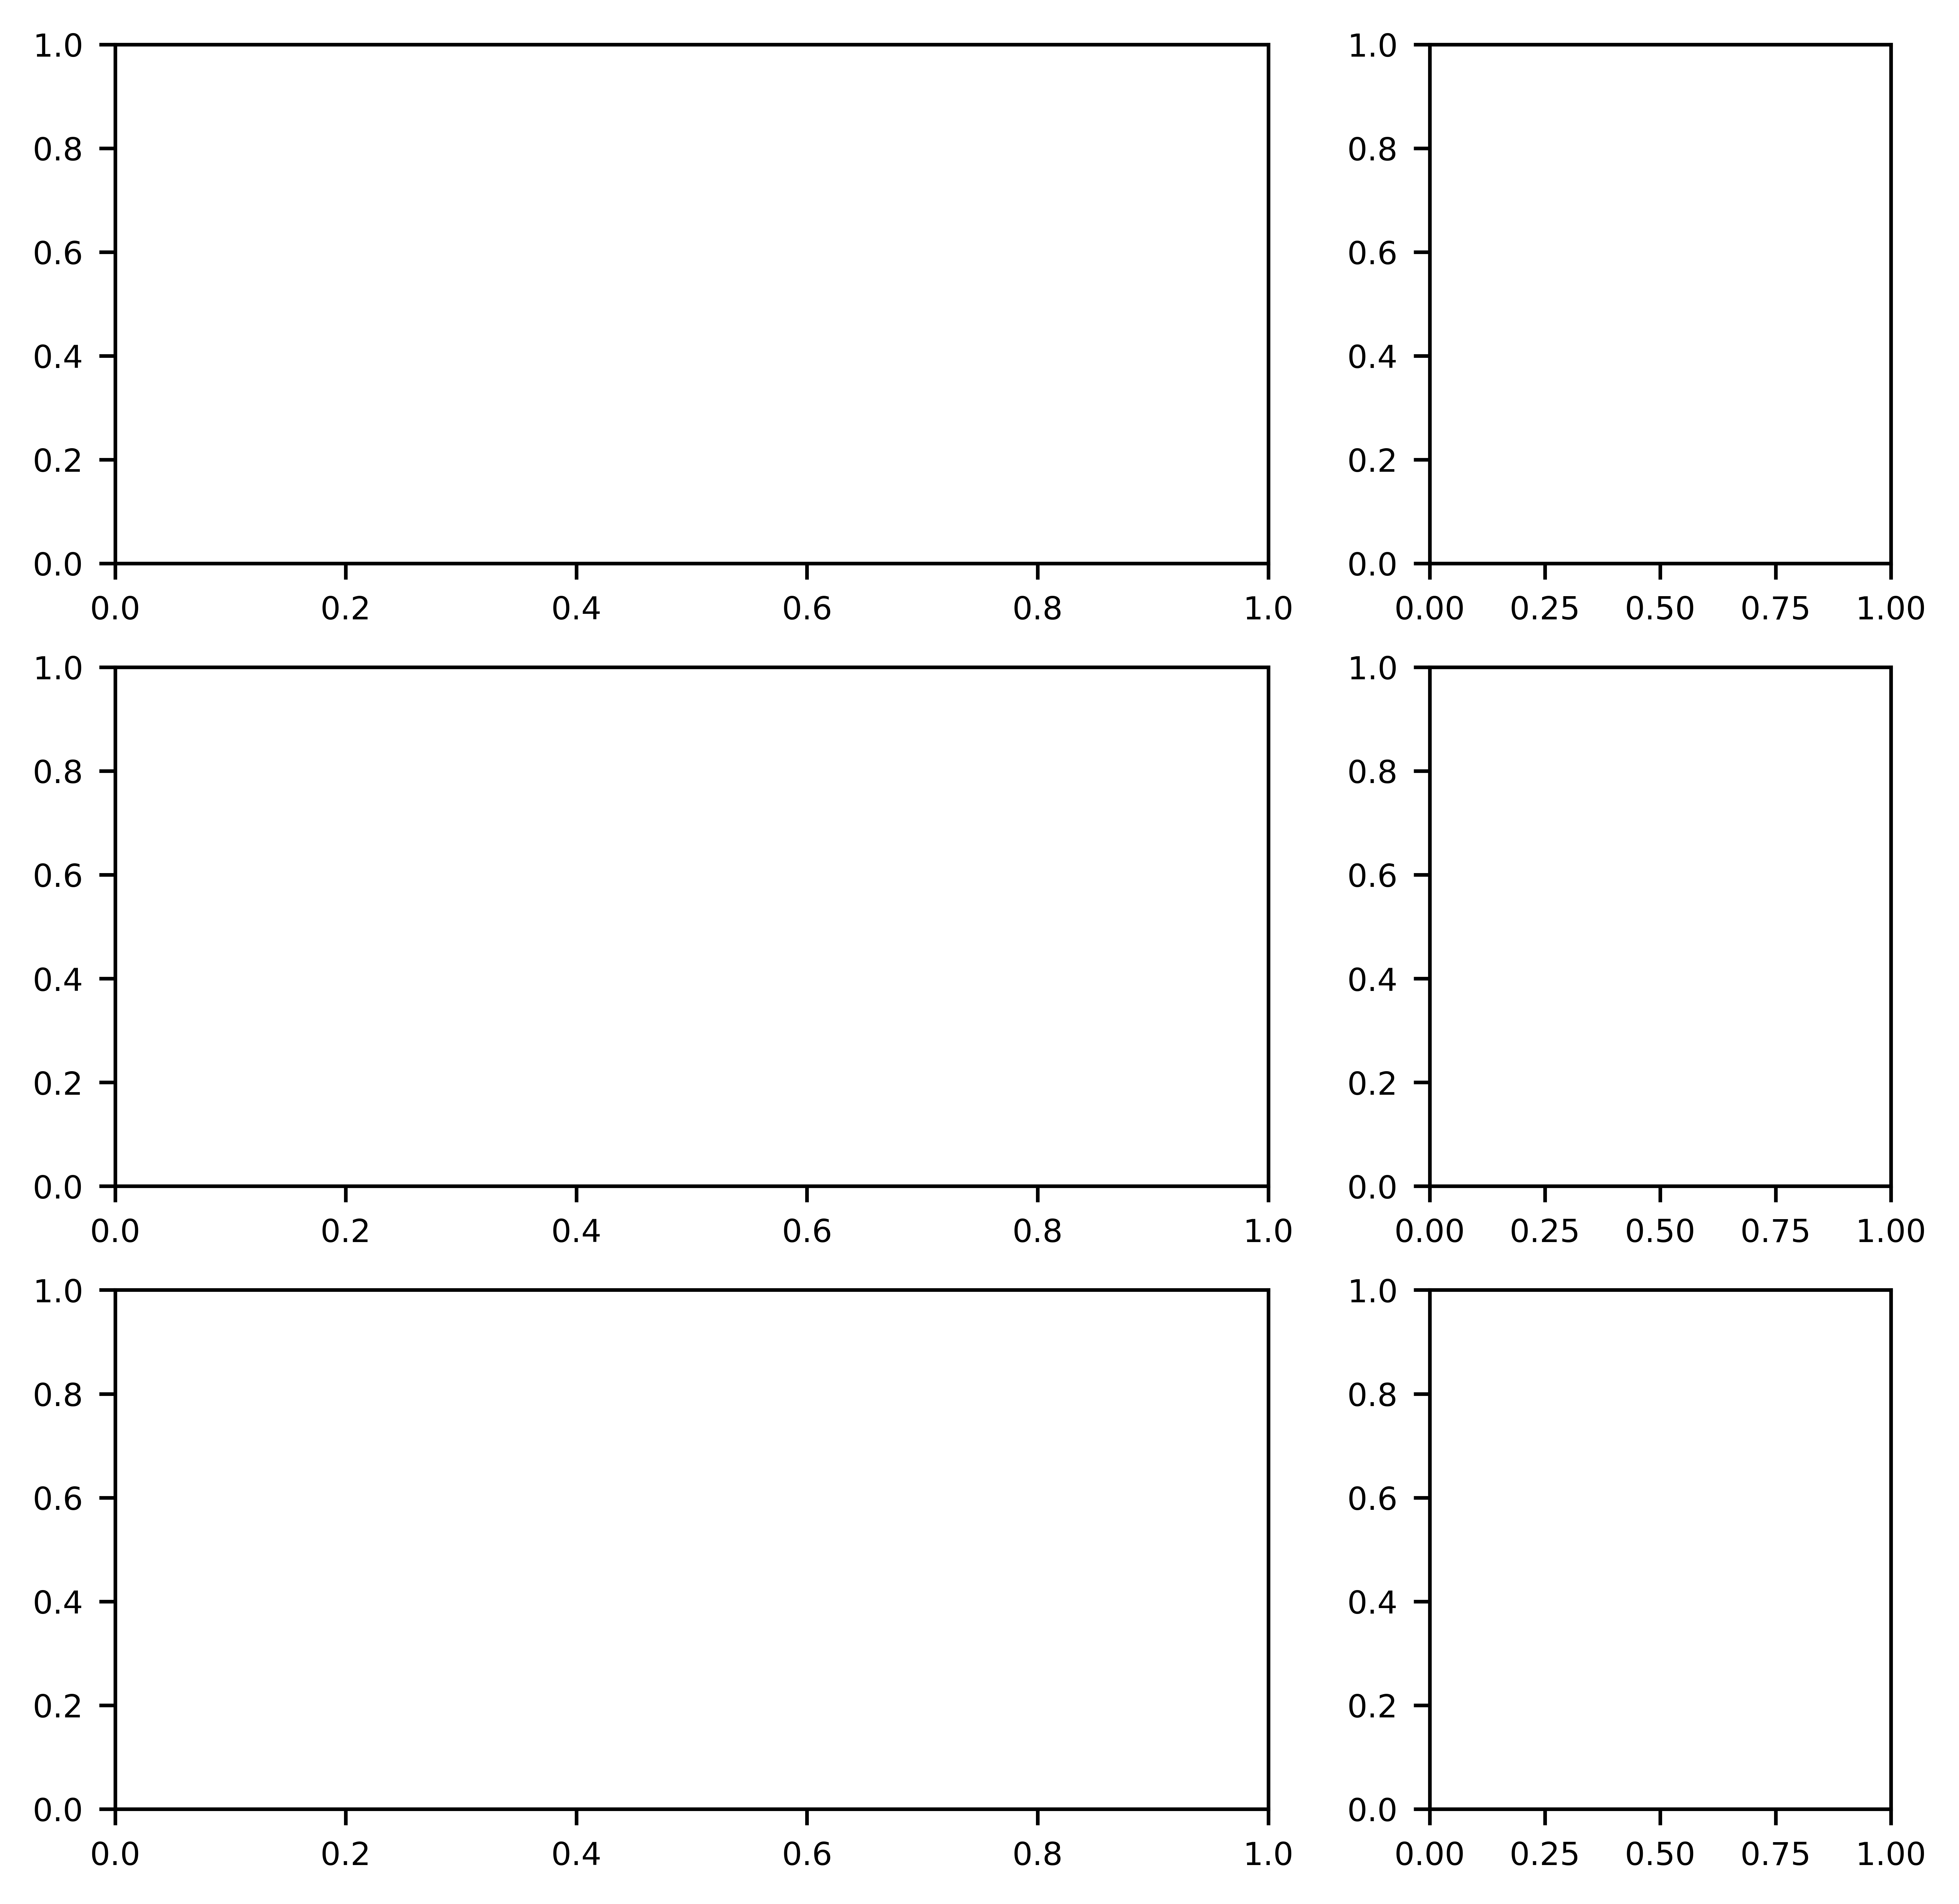

In [101]:
pattern_names = ['Pattern S-A', 'Pattern Act-D', 'Pattern M-V']
colors = ['#F8B77C', '#D54D55', '#381043', 'grey']


fig, axs = plt.subplots(3, 2, figsize=(7, 7), dpi=1000, width_ratios=[2.5, 1])

prediction_dict = np.load(f'{dir_02}/cogscore.npy', allow_pickle=True).item()

for comp in range(3):
    """
    Pattern Visualization
    """
    ax = axs[comp, 0]
    ax.imshow(list_img[comp])
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='80%', pad=0.3)

    
    """
    Bar graph
    """
    ax = cax
    # ax.set_title(['B.', 'E.', 'H.'][comp], loc='left', x=-.15)
    
    angle_us = np.mod(np.angle(list_U[:, :,  comp]), 2 * np.pi)
    bins = np.linspace(0, 2 * np.pi, n_bin + 1)
    bin_idx = np.digitize(angle_us, bins) - 1
    bcounts = np.asarray([(bin_idx == i).sum(axis=1) for i in range(n_bin)])
    
    # rs, ps = np.asarray([spearmanr_with_covariate(age, bcounts[i], mfd) for i in range(n_bin)]).T
    rs, ps = np.asarray([spearmanr(age, bcounts[i]) for i in range(n_bin)]).T
    sig_phase = np.where(correct_p(ps) < 0.05)[0]
    tend_phase = np.setdiff1d(np.where(ps < 0.05)[0], sig_phase)


    all_bins = np.arange(n_bin)
    for i in all_bins:
        if i in sig_phase:
            alpha_val = 1.0
        elif i in tend_phase:
            alpha_val = 0.5
        else:
            alpha_val = 0.2
        
        if rs[i] > 0:
            bar_color = plt.get_cmap('RdYlBu_r')(225)
        else:
            bar_color = plt.get_cmap('RdYlBu_r')(30)
        
        ax.bar(i, rs[i], align='edge', color=bar_color, alpha=alpha_val)

    
    # ax.bar(np.where(rs > 0)[0], rs[np.where(rs > 0)], align='edge', color=plt.get_cmap('RdYlBu_r')(225))
    # ax.bar(np.where(rs < 0)[0], rs[np.where(rs < 0)], align='edge', color=plt.get_cmap('RdYlBu_r')(30))

    ax.grid(True, linestyle='--', alpha=0.2)
    ax.set_xticks(np.linspace(0, n_bin, 5, endpoint=True), ['0', '$\pi$/2', '$\pi$', '3$\pi$/2', '2$\pi$'])
    ax.spines[['bottom', 'right']].set_visible(False)
    ax.set_yticks([-.2, 0, .2])
    ax.xaxis.tick_top()
    # ax.invert_yaxis()
    # print(np.sort(rs))

    # ps = np.asarray([spearmanr(age, bcounts[i]) for i in range(n_bin)])[:, 1]
    # print('Valid phase')

    cax.set_ylim(-.24, .24)
    cax.plot(sig_phase + 0.4, rs[sig_phase] * 1.2, 'k*', ms=4) 
    cax.plot(tend_phase + 0.4, rs[tend_phase] * 1.2, 'k+', ms=4) 
    cax.set_ylabel('Age effect (r)', labelpad=0, y=.62)
    cax.set_xlabel('Phase:', x=-.02, labelpad=-56)
    
    """
    Cognitive score prediction
    """
    ax = axs[comp, 1]
    
    # ax.set_title(['C.', 'F.', 'I.'][comp] + ' Cognitive score prediction', loc='left', x=-.3, pad=10)
    adjust_ax(ax, dy=.015)
    
    data = prediction_dict[comp]


    mean_vals = np.mean(data, axis=1)
    std_vals = np.std(data, axis=1)   # or use standard error if preferred
    x_inds = np.arange(4) + .5
    ax.clear()
    ax.bar(x_inds, mean_vals, yerr=std_vals,
       color=colors[comp], alpha=0.9, capsize=4)

    ratio = get_ratio(np.arange(5), data) * 0.8
    ax.set_aspect(ratio, adjustable='box')    

    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks(np.arange(5), ['0', '$\pi$/2', '$\pi$', '3$\pi$/2', '2$\pi$'])
    ax.set_yticks([.1, .2, .3])
    ax.set_ylim(np.min(data) * .9, np.max(data) * 1.1)
    ax.set_xlabel('Phase')
    ax.set_ylabel('Prediction score (r)')